# Experiment: Label Noise and Fairness-Performance Tradeoff
This experiment evaluates how label noise affects the tradeoff between fairness and performance in a classification task. We implement the 2LR Plugin-Approach (from Bob's paper) and analyze synthetic data under various levels of label noise.

## 1. Import Libraries

In [11]:
from random import seed, shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sys
sys.path.insert(1, '/home/ptr@itd.local/code/fairness_triangle/tools')  # Update this path as needed
from gen_synth_data import *
from plot_helper import *
from corrupt_labels import *
from calc_metrics import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scienceplots

plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.7,
    'xtick.major.pad': 7
})


## 2. Configuration

In [19]:
rnd_seed = 0             # Fixed randomness for reproducability
flip_prob = 0.1          # Binary Label Noise probability
flip_prob_0_to_1 = 0.1
flip_prob_1_to_0 = 0.3
disc_factor = np.pi/4     # Similarity of Y_sen to X
n_samples = 5000         # Number of samples per distribution (We have 2x in total)
split_ratio = 0.7        # Split into train and test set
c = 0.5                  # Cost of performance and fairness (Eq. 15 )
c_bar = 0.5  
lmd = 0.5                # Trade off between perf and fairn regressions (only used in vizualization)
lmd_start= -1
lmd_end= 1
lmd_interval = np.linspace(lmd_start, lmd_end, 40)
symmetric_fairness = False

In [ ]:
def evaluate_and_plot(X_train, Y_train, X_test, Y_test, Y_sen_test,
                      Y_corrupted, p_reg, f_reg, ax, title):
    # fit with corrupted labels
    Y_corr_train, Y_corr_test = Y_corrupted[:split_index], Y_corrupted[split_index:]
    p_reg_cor = LogisticRegression().fit(X_train, Y_corr_train)

    # sweep over lambda
    BER_list, MD_list, ACC_list = [], [], []
    BER_list_corr, MD_list_corr, ACC_list_corr = [], [], []

    for lmd in lmd_interval:
        # clean predictions
        s = p_reg.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred = np.where(s > 0, 1, 0)
        BER_list.append(calc_BER(Y_pred, Y_test))
        MD_list.append(calc_MD(Y_pred, Y_sen_test, symmetric_fairness))
        ACC_list.append(calc_ACC(Y_pred, Y_test))

        # corrupted predictions
        s2 = p_reg_cor.predict_proba(X_test)[:, 1] - c - lmd * (f_reg.predict_proba(X_test)[:, 1] - c_bar)
        Y_pred2 = np.where(s2 > 0, 1, 0)
        BER_list_corr.append(calc_BER(Y_pred2, Y_test))
        MD_list_corr.append(calc_MD(Y_pred2, Y_sen_test, symmetric_fairness))
        ACC_list_corr.append(calc_ACC(Y_pred2, Y_test))

    # pack results (now MD instead of DI)
    results = pd.DataFrame({
        "lambda": lmd_interval,
        "ACC_clean": ACC_list, "ACC_corr": ACC_list_corr,
        "MD_clean": MD_list, "MD_corr": MD_list_corr,
    })

    # plot MD vs ACC
    df = results.sort_values("lambda")
    lambda_norm = (df["lambda"] - df["lambda"].min()) / (df["lambda"].max() - df["lambda"].min())
    orange_cmap = truncate_colormap('Oranges', 0.2, 1.0)
    green_cmap = truncate_colormap('Greens', 0.2, 1.0)

    
    ax.plot(df["MD_corr"], df["ACC_corr"], color="forestgreen", linewidth=2)
    ax.plot(df["MD_clean"], df["ACC_clean"], color="darkorange", linewidth=2)
    
    ax.scatter(df["MD_corr"], df["ACC_corr"], c=lambda_norm, cmap=green_cmap, s=28, label="Corrupted", marker="s")
    ax.scatter(df["MD_clean"], df["ACC_clean"], c=lambda_norm, cmap=orange_cmap, s=28, label="Clean")
    
    ax.set_title(title)
    ax.set_xlim(-1, 1); ax.set_ylim(0, 1)
    ax.set_xlabel("MD", fontsize=18)
    ax.set_ylabel("Accuracy", fontsize=20)

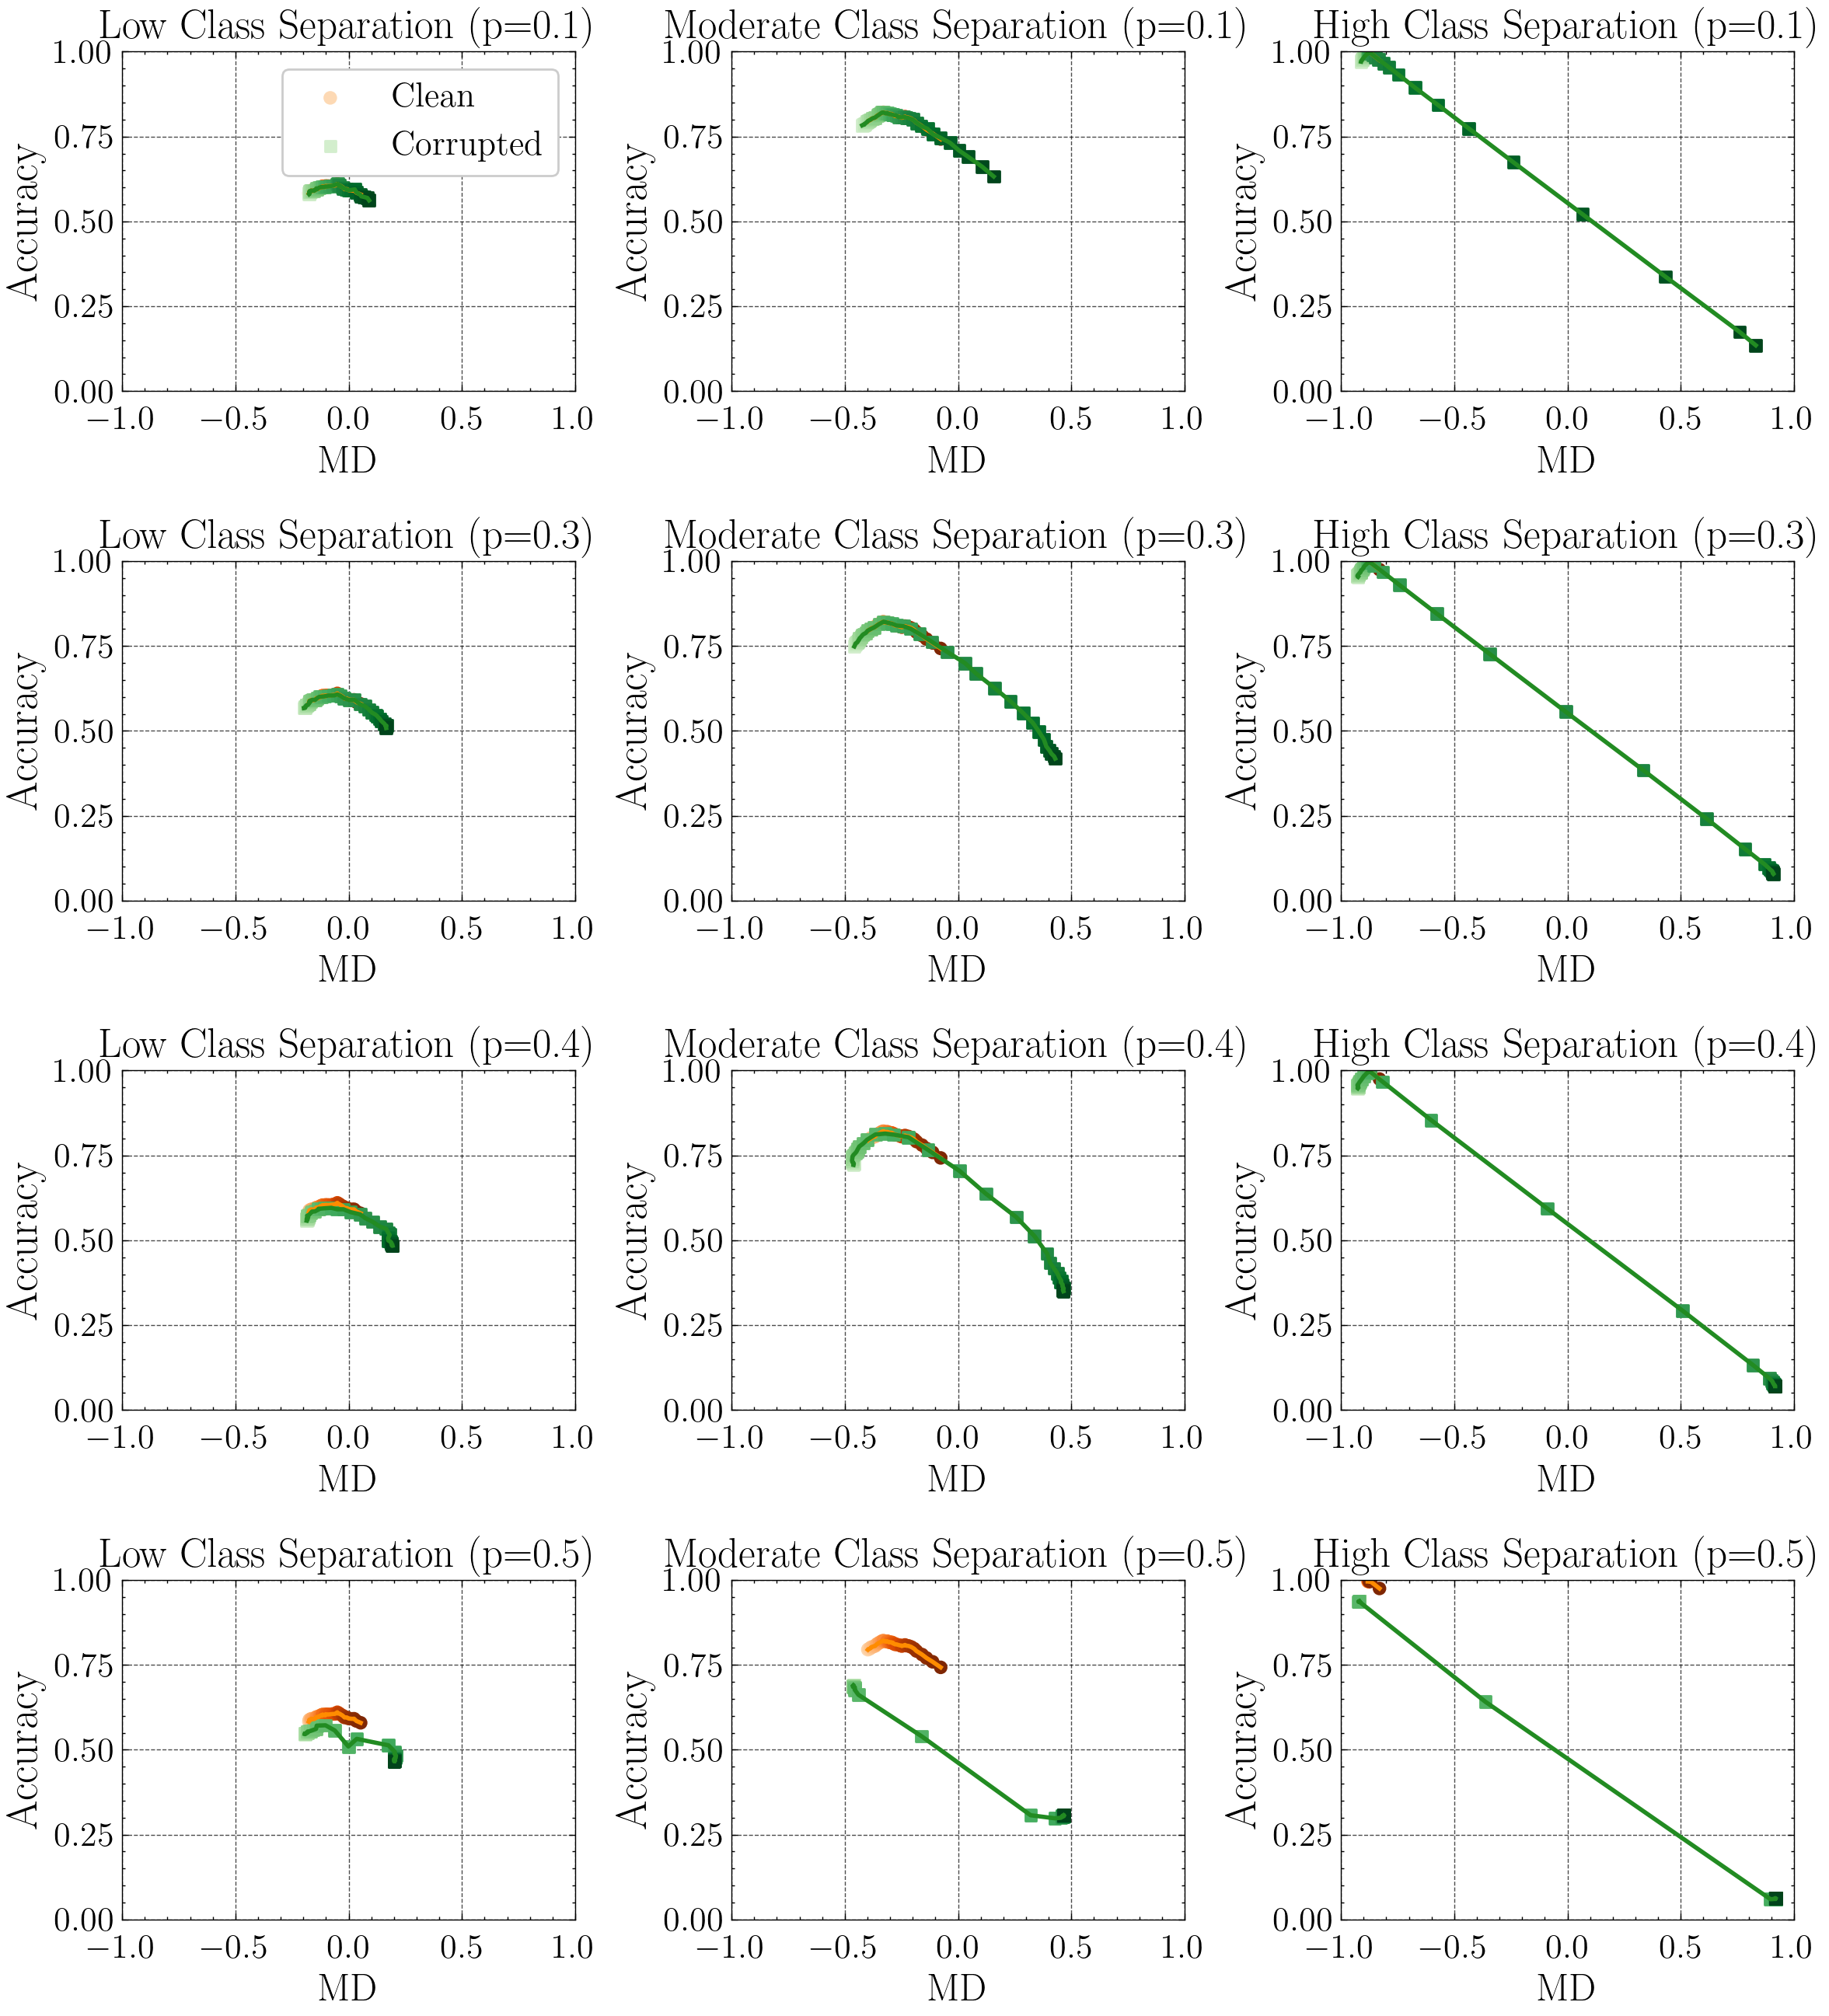

In [21]:
# =======================
# Build 3x4 subplot grid
# =======================

p_values = [0.1, 0.3, 0.4, 0.5]   # rows
mean_pairs = [
    (np.array([0.5, 0.5]),  np.array([0.5, -0.5])),
    (np.array([1.5, 1.5]),  np.array([-1.5, -1.5])),
    (np.array([5., 5.]),  np.array([-5., -5.])),
]
dataset_titles = [
    "Low Class Separation",
    "Moderate Class Separation",
    "High Class Separation"
]

fig, axes = plt.subplots(len(p_values), len(mean_pairs), figsize=(12, 13.35), sharex=False, sharey=False)

for i, p in enumerate(p_values):               # rows
    for j, means in enumerate(mean_pairs):     # columns
        ax = axes[i, j]

        # Generate synthetic data
        X, Y, Y_sen = get_syn_data_custom(means[0], means[1], n_samples, disc_factor, rnd_seed)
        Y_corr = add_sym_noise(Y, p, rnd_seed)

        # Train/test split
        split_index = int(split_ratio * len(X))
        X_train, X_test = X[:split_index], X[split_index:]
        Y_train, Y_test = Y[:split_index], Y[split_index:]
        Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]

        p_reg = LogisticRegression().fit(X_train, Y_train)
        f_reg = LogisticRegression().fit(X_train, Y_sen_train)

        # Plot
        title = f"{dataset_titles[j]} (p={p})"
        evaluate_and_plot(X_train, Y_train, X_test, Y_test, Y_sen_test,
                          Y_corr, p_reg, f_reg, ax, title)

        # Add legend only once (top-left corner)
        if i == 0 and j == 0:
            ax.legend()

fig.tight_layout()
plt.show()


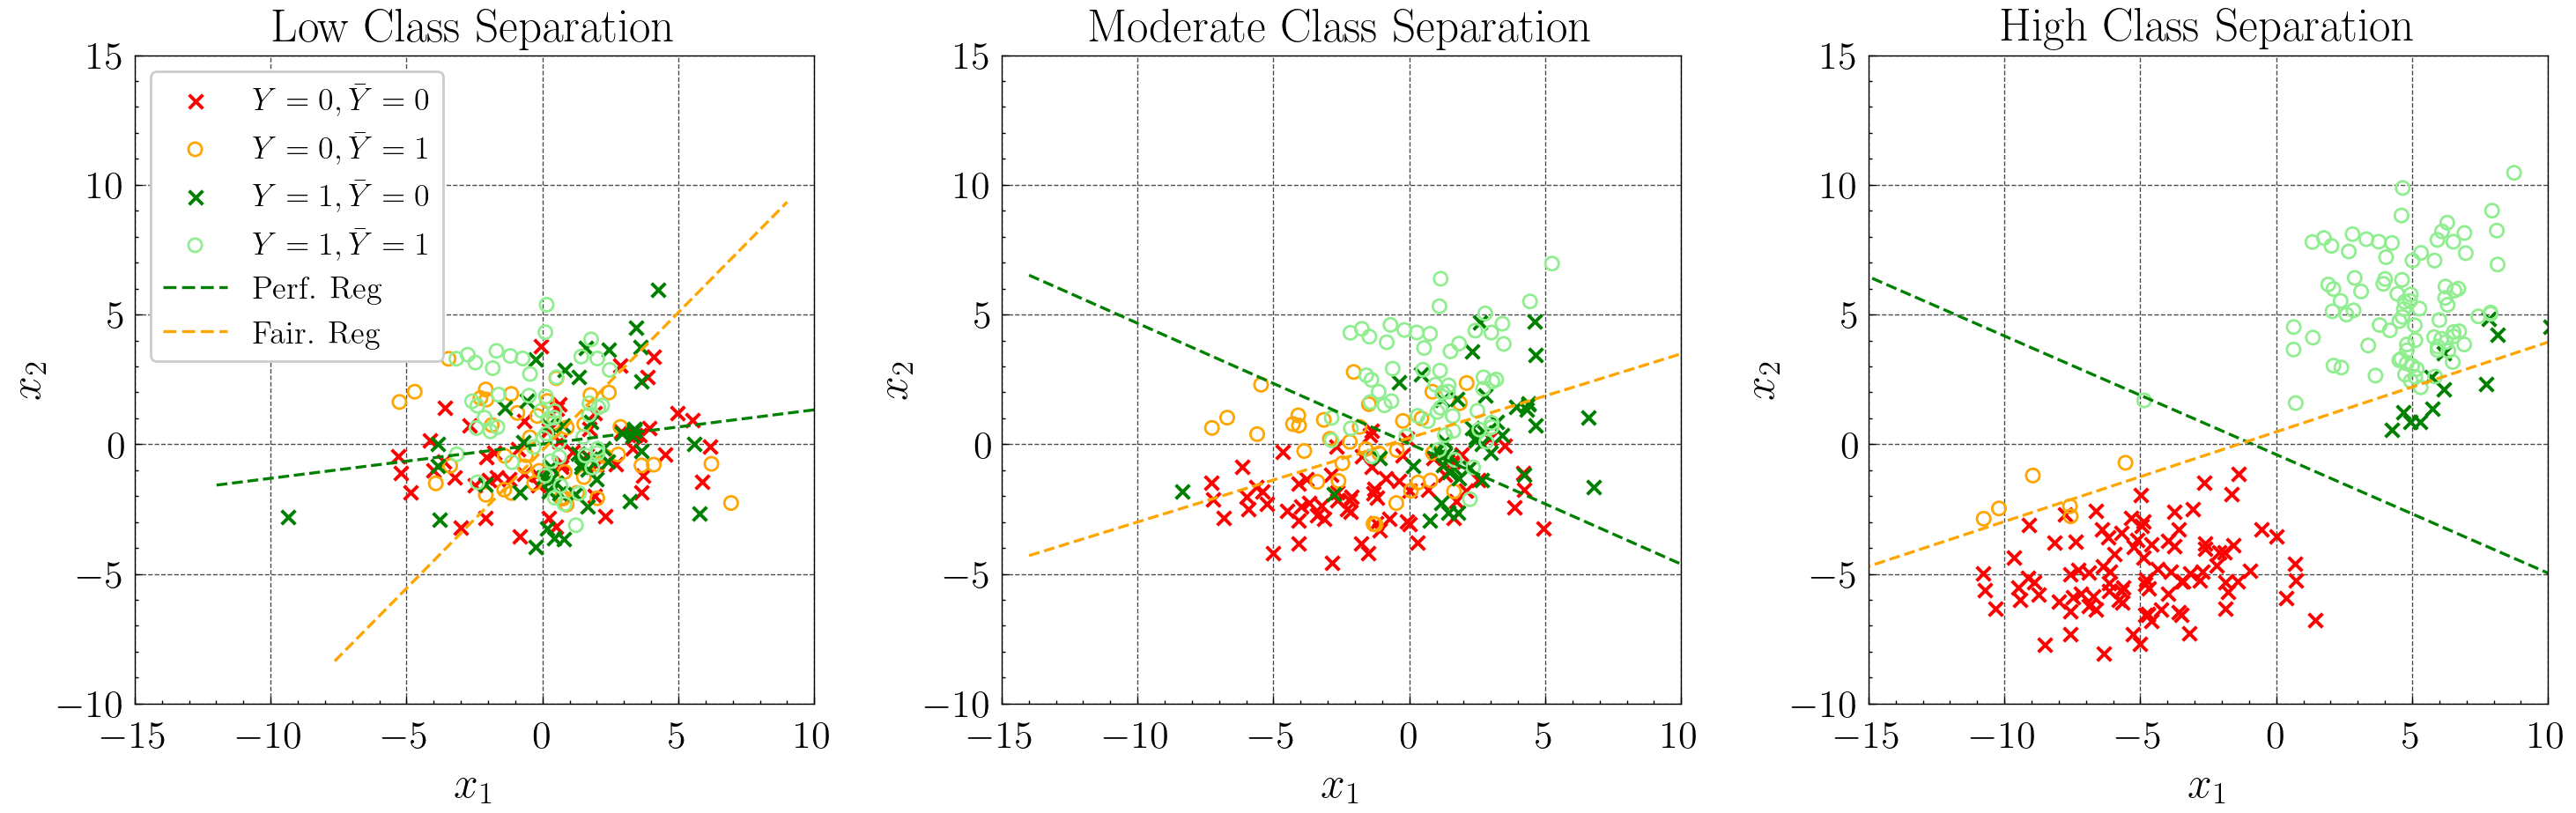

In [22]:
# =======================
# 1x3 subplot grid with decision regions
# =======================

fig, axes = plt.subplots(1, len(mean_pairs), figsize=(15, 5))

for j, means in enumerate(mean_pairs):
    ax = axes[j]

    # Generate synthetic data
    X, Y, Y_sen = get_syn_data_custom(means[0], means[1], n_samples, disc_factor, rnd_seed)

    # Train/test split
    split_index = int(split_ratio * len(X))
    X_train, X_test = X[:split_index], X[split_index:]
    Y_train, Y_test = Y[:split_index], Y[split_index:]
    Y_sen_train, Y_sen_test = Y_sen[:split_index], Y_sen[split_index:]

    # Train regressors
    p_reg = LogisticRegression().fit(X_train, Y_train)
    f_reg = LogisticRegression().fit(X_train, Y_sen_train)

    # Subsample points for visualization
    num_to_draw = 200
    x_draw = X[:num_to_draw]
    y_draw = Y[:num_to_draw]
    Y_sen_draw = Y_sen[:num_to_draw]

    X_s_0 = x_draw[Y_sen_draw == 0.0]
    X_s_1 = x_draw[Y_sen_draw == 1.0]
    y_s_0 = y_draw[Y_sen_draw == 0.0]
    y_s_1 = y_draw[Y_sen_draw == 1.0]

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),
        np.arange(y_min, y_max, 0.02)
    )
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict decision surfaces
    Y_pred_p = p_reg.predict_proba(grid_points)[:, 1].reshape(xx.shape)
    Y_pred_f = f_reg.predict_proba(grid_points)[:, 1].reshape(xx.shape)

    # Call your helper plotting function
    subplot_reg_without_y_pred(
        ax, Y_pred_p, Y_pred_f,
        xx, yy,
        X_s_0, y_s_0,
        X_s_1, y_s_1,
        legend_flag=(j == 0)  # show legend only in first plot
    )

    ax.set_xlim(-15, 10); ax.set_ylim(-10, 15)
    ax.set_title(dataset_titles[j])
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

fig.tight_layout()
plt.show()


## 7. Reproducibility Notes
- Python version: 3.11.5
- Libraries: numpy, matplotlib, sklearn, pandas
- Custom modules: `gen_synth_data`, `plot_helper`, etc.
- Random seed: 0
